In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


In this notebook we will compute a wavelet dictionary on the KGnn v2

# Data ingestion

## Load scRNAseq data

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [4]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [5]:
%%R -i data_dir -o dRnaSeq,dPHATEcoord
library(tidyverse)
library(Seurat)

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


AxisArrays with keys: 
Before filtering we have 20867 genes
After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

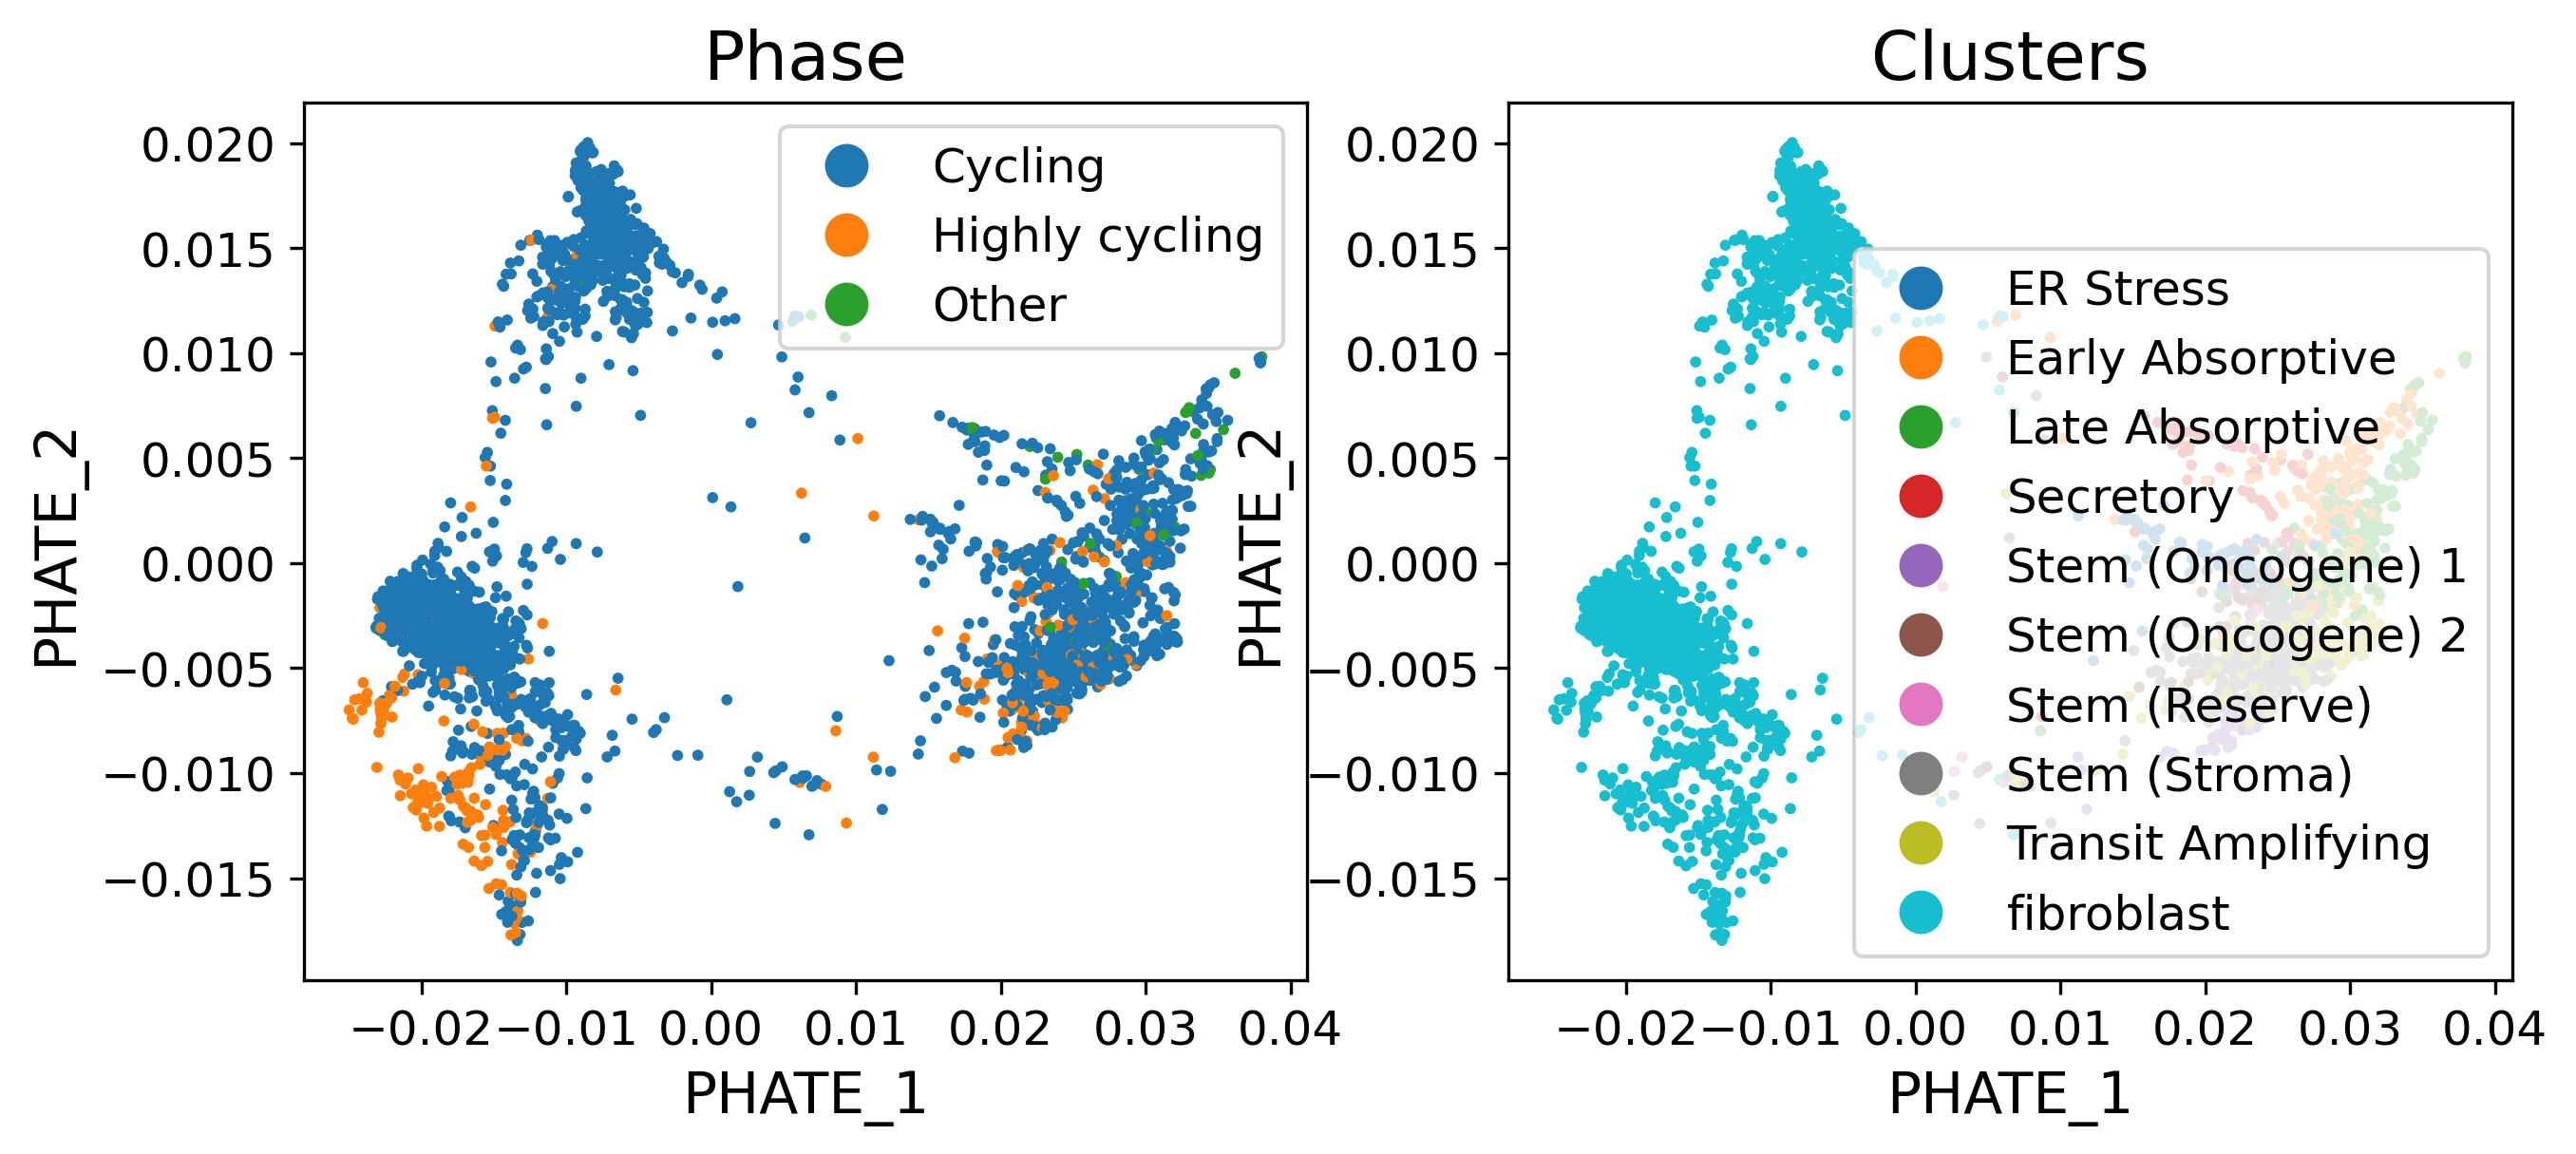

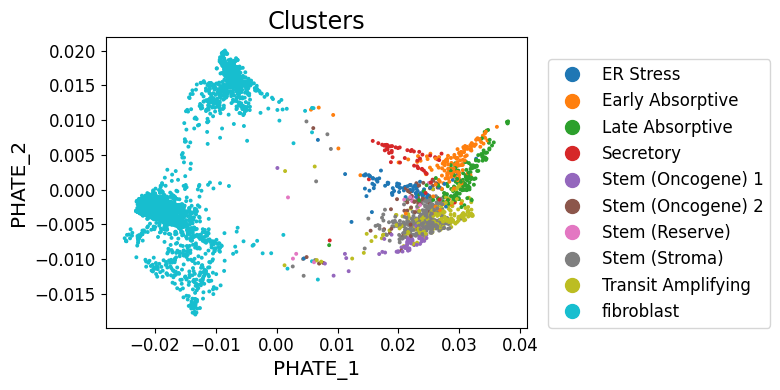

In [6]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

## Process data to human
Convert SEQ data to HGNC symbols

In [7]:
from biomart import BiomartServer

mart = BiomartServer("http://useast.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [8]:
dSEQmd = dRnaSeq.obs
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1300017J02Rik,1500009C09Rik,1700015F17Rik,1700020D05Rik,1700030C10Rik.1,1810026B05Rik,2010300C02Rik,...,ZYX,ZZEF1,ZZZ3,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.0,0.0,0.0,0.0,0.0,0.657148,0.0,...,0.657148,0.657148,0.657148,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.0,0.0,0.0,0.0,0.0,0.498218,0.0,...,0.498218,0.000000,0.829238,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.0,0.0,0.0,0.0,0.0,0.787727,0.0,...,1.028759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.0,0.0,0.0,0.0,0.0,0.402734,0.0,...,0.000000,0.221506,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.695505,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,1.071710,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.0,0.0,0.0,0.0,0.0,1.015210,0.0,...,0.461624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.0,0.0,0.0,0.0,0.0,0.615369,0.0,...,0.993504,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


### Pre-processing: MAGIC

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Return only genes in KG.

In [10]:
#Load nodes from KG
import json
with open(f"{data_dir}/dKGnn2_entityIDS.json") as infile:
    entityIDS = json.load(infile)

magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq,
    genes = dRnaSeq.columns[dRnaSeq.columns.isin(entityIDS.values())]
)
del magic_op,dRnaSeq
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 13756 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.58 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.01 seconds.
    Calculating affinities...
    Calculated affinities in 0.99 seconds.
  Calculated graph and diffusion operator in 4.73 seconds.
  Calculating imputation...
  Calculated imputation in 1.52 seconds.
Calculated MAGIC in 10.03 seconds.


,A1CF,AACS,AAK1,AAMP,AARS2,AASDHPPT,AASS,ABCA1,ABCA12,ABCA4,...,ZNRF1,ZNRF2,ZNRF3,ZRANB1,ZRSR2,ZSCAN25,ZSWIM8,ZW10,ZWILCH,ZWINT
WT__AAACCCACAGCTTCCT-1,0.000000,0.062274,0.166787,0.847318,0.017653,0.434658,0.000219,0.185436,0.000000,0.000270,...,0.277662,0.074992,0.030079,0.148179,0.053037,0.006242,0.116870,0.052062,0.004309,0.378821
WT__AAACCCAGTTCGAGCC-1,0.000000,0.071173,0.186584,0.876674,0.027500,0.473611,0.000173,0.177385,0.000000,0.000189,...,0.226016,0.070318,0.024699,0.141090,0.067742,0.018253,0.101846,0.048728,0.046125,0.371247
WT__AAACGAAAGAAGGATG-1,0.000000,0.088493,0.162591,0.895362,0.014154,0.376967,0.001296,0.182863,0.000000,0.000596,...,0.274433,0.070251,0.014828,0.108166,0.035152,0.005129,0.110356,0.074306,0.003915,0.405967
WT__AAACGAAAGGAAAGGT-1,0.202481,0.041011,0.081466,0.346242,0.006396,0.068019,0.005973,0.000120,0.003653,0.000087,...,0.084422,0.299727,0.000000,0.154256,0.024774,0.000183,0.079995,0.011237,0.000000,0.256515
WT__AAACGAAAGTTAACGA-1,0.029256,0.095724,0.057729,0.523029,0.014065,0.199522,0.010988,0.000989,0.003276,0.003060,...,0.213690,0.103585,0.003321,0.076159,0.010410,0.004172,0.061385,0.028996,0.003092,0.579361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.003508,0.038438,0.154692,0.387039,0.051152,0.148090,0.000188,0.002513,0.002099,0.000241,...,0.097536,0.212026,0.000019,0.112051,0.029289,0.000022,0.188320,0.016672,0.000382,0.727171
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.079477,0.234805,0.790908,0.032891,0.354448,0.000904,0.259488,0.000000,0.000174,...,0.253371,0.084588,0.021346,0.164282,0.080004,0.006514,0.151128,0.072940,0.010044,0.368586
WT__TTTGTTGTCGCTTGAA-1,0.083869,0.110456,0.066512,0.468573,0.007102,0.136753,0.008069,0.002443,0.002880,0.008604,...,0.161028,0.175049,0.000676,0.096866,0.033411,0.001703,0.099100,0.018384,0.000030,0.370164
WT__TTTGTTGTCTGAATCG-1,0.000322,0.063447,0.196279,0.939646,0.007513,0.472171,0.000114,0.183279,0.000000,0.000000,...,0.355109,0.086620,0.027668,0.195599,0.030377,0.003054,0.078632,0.074824,0.002201,0.758733


KeyError: 'EPCAM'

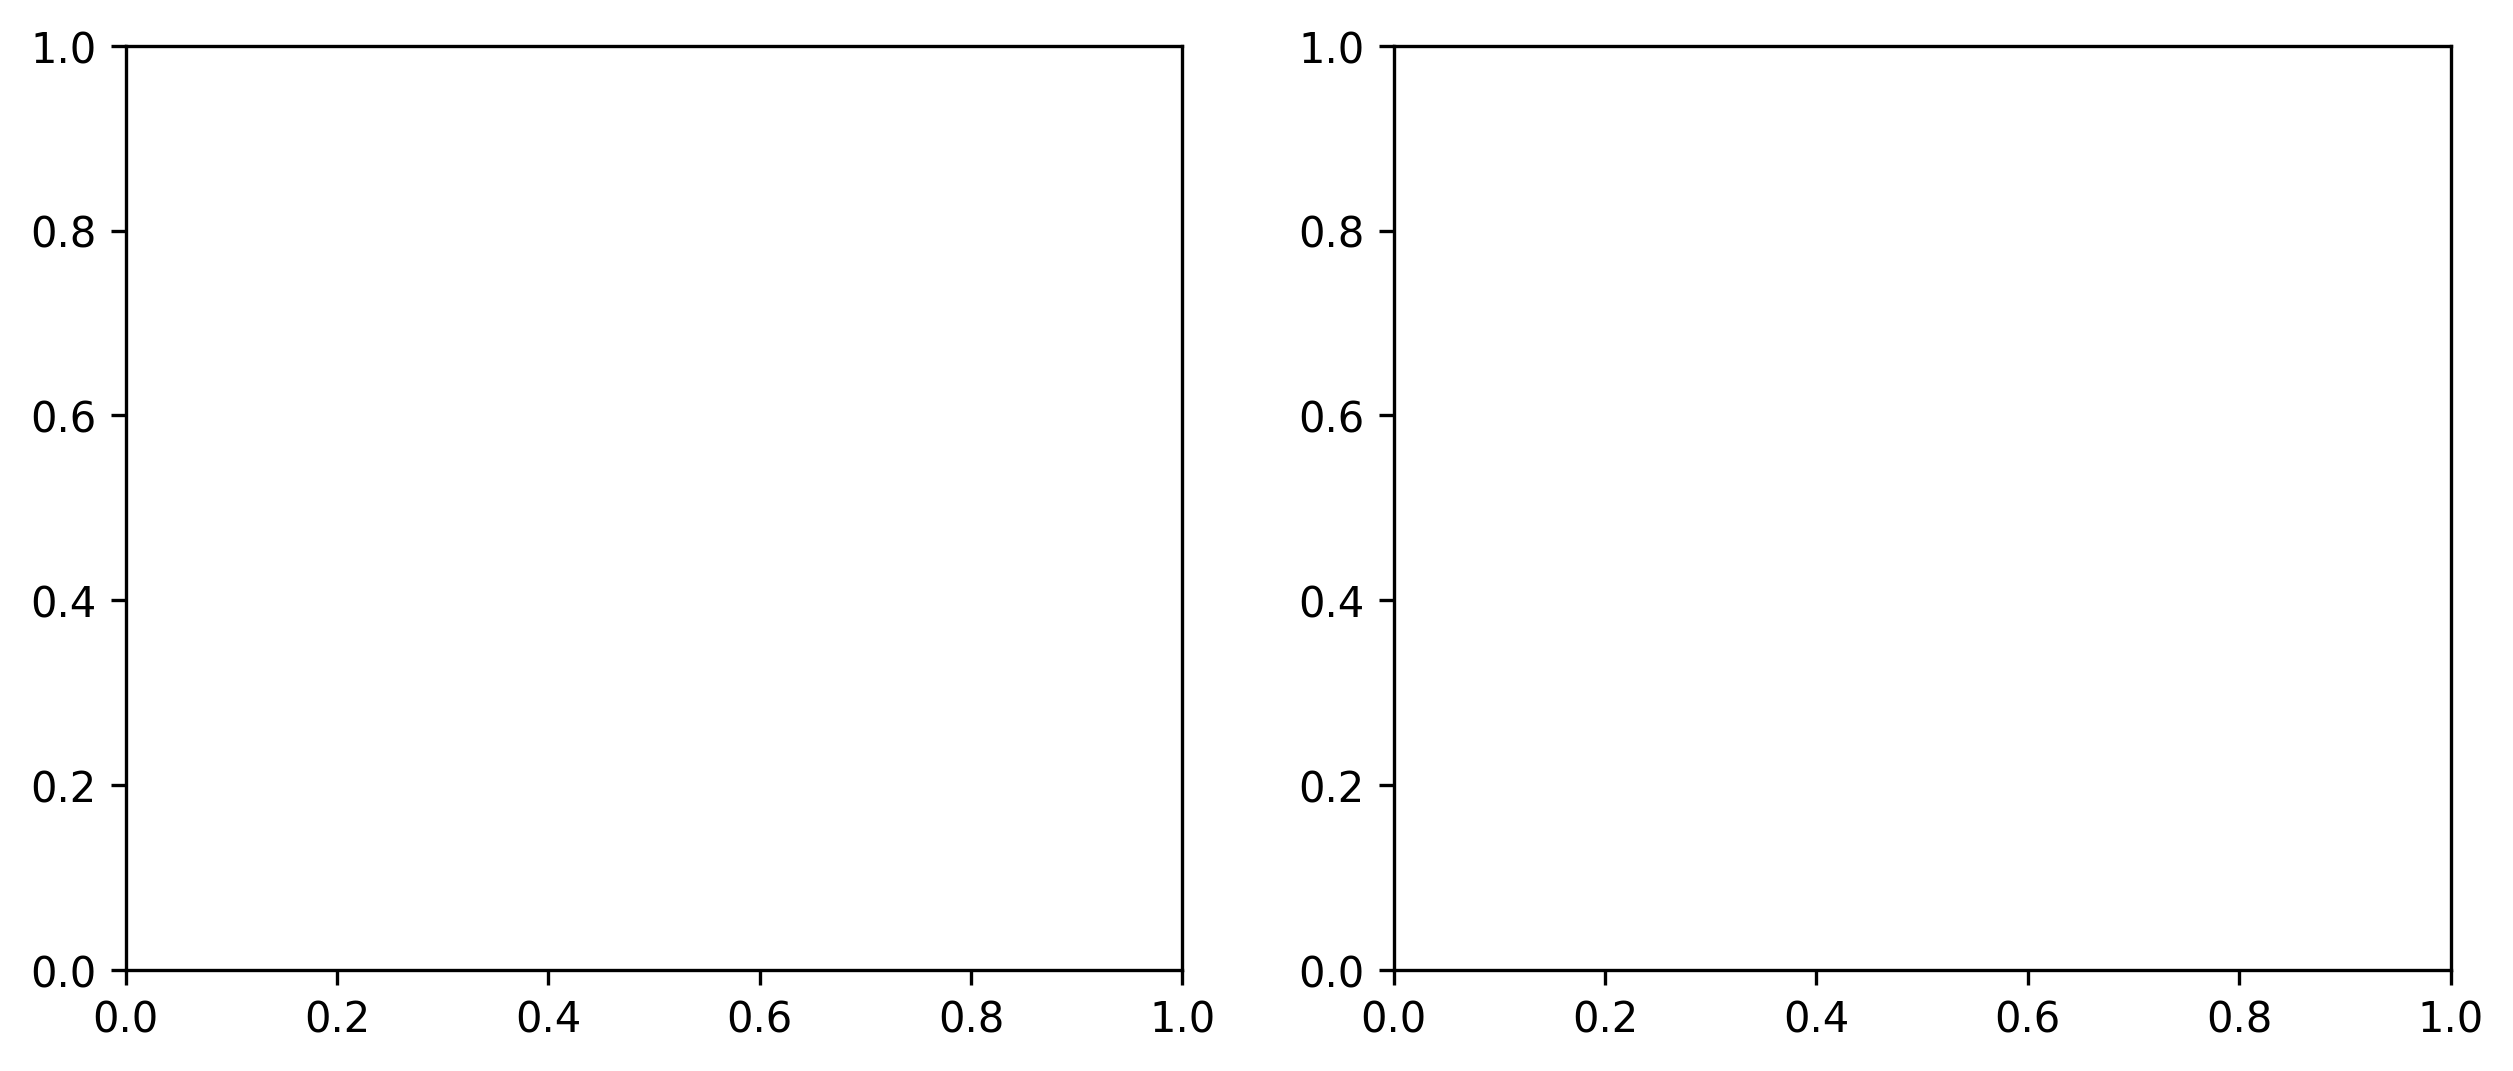

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Vim"]], y=dMagicRnaSeq[mouse2human["Cd34"]], 
    c=dMagicRnaSeq[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Epcam"]], y=dMagicRnaSeq[mouse2human["Fabp2"]], 
    c=dMagicRnaSeq[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

In [14]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn2.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
34393,R-HSA-9013148,Path2Gene,ARHGAP11B
34394,R-HSA-9752946,Path2Gene,OR4F4
34395,R-HSA-156588,Path2Gene,UGT1A5
34396,R-HSA-9749641,Path2Gene,UGT1A5
